## Market1501 / cuhk03 

{'UMPM': {'password': 'ahJaka4o', 'username': 'umpmuser'},
 'data_root': '/home/DATA'}



Using TensorFlow backend.


/home/DATA/cuhk03_release found :)
/home/DATA/Market-1501-v15.09.15 found :)
/home/DATA/DukeMTMC-reID found :)
found memmaped /home/DATA/cuhk03_release/labeled221x221.npy
(cuhk) positive test pairs: 9290
(cuhk) positive train pairs: 127242
(market) positive test pairs:  300631
(market) positive train pairs:  309874
load memmap /home/DATA/DukeMTMC-reID/bounding_box_test221x221.npy
load memmap /home/DATA/DukeMTMC-reID/bounding_box_train221x221.npy
(duke) positive test pairs:  926089
(duke) positive train pairs:  749270
(6, 221, 221, 6)
is same: [1 0]
is same: [1 0]
is same: [0 1]
is same: [0 1]
is same: [1 0]
is same: [0 1]


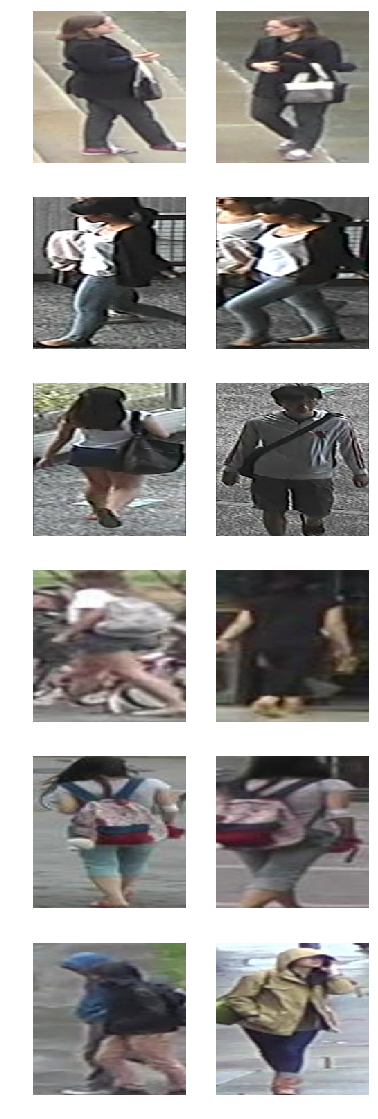

In [1]:
%matplotlib inline
import json
from pprint import pprint
Settings = json.load(open('settings.txt'))
pprint(Settings)
print('')
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
from reid.stacknet import get_model
from reid.data import DataSampler

from keras.callbacks import ModelCheckpoint, TerminateOnNaN
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
from os.path import join, isfile, isdir, exists, splitext

root = Settings['data_root']

sampler = DataSampler(root, 221, 221)

npos = 3
nneg = 3
x, y = sampler.get_test_batch(npos, nneg)
#n = npos + nneg
n = len(x)
print(x.shape)

fig = plt.figure(figsize=(6, 20))
for pid in range(n):
    print('is same:', y[pid])
    im = x[pid]
    ax = fig.add_subplot(n, 2, pid*2+1); ax.axis('off')
    ax.imshow(im[:,:,0:3])
    ax = fig.add_subplot(n, 2, pid*2+2); ax.axis('off')
    ax.imshow(im[:,:,3:6])
plt.show()

## UMPM dataset

/home/DATA
UMPM
elapsed 0.08214831352233887
same [1 0]
(32, 221, 221, 6)


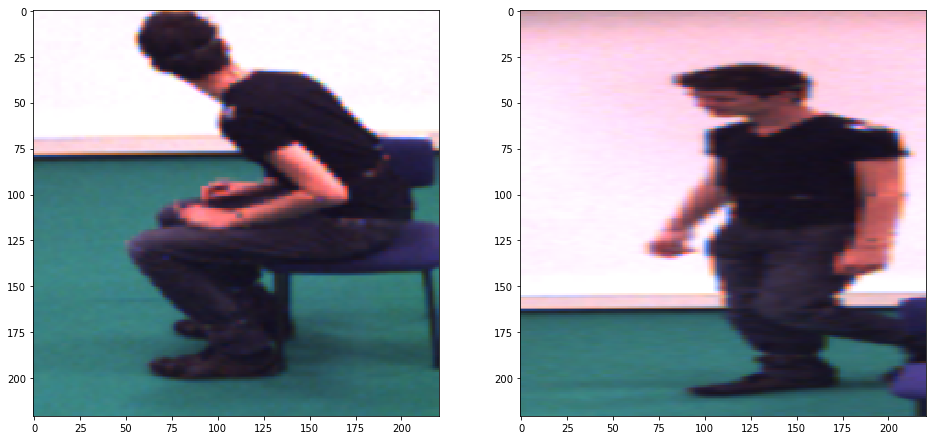

In [2]:
from time import time
from reid.data import UMPMSampler

root = Settings['data_root']
print(root)

user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']
umpm_sampler = UMPMSampler(root, ['p2_chair_2'], user, pwd, 221, 221)


_start = time()
x, y = umpm_sampler.get_train()
_end = time()
print('elapsed', _end - _start)

print('same', y[0])

print(x.shape)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax.imshow(x[0, :, :, 0:3].astype('uint8'))
ax = fig.add_subplot(122)
ax.imshow(x[0, :, :, 3:6].astype('uint8'))
plt.show()

## MOT16 dataset

/home/DATA/MOT16 found :)
MOT16: load memmapped file /home/DATA/MOT16/train/MOT16-02/data.memmap
MOT16 X loaded
MOT16 Y_det loaded
MOT16 Y_gt loaded
(MOT16) total number of bounding boxes: 1736
elapsed 0.04754829406738281
same [1 0]


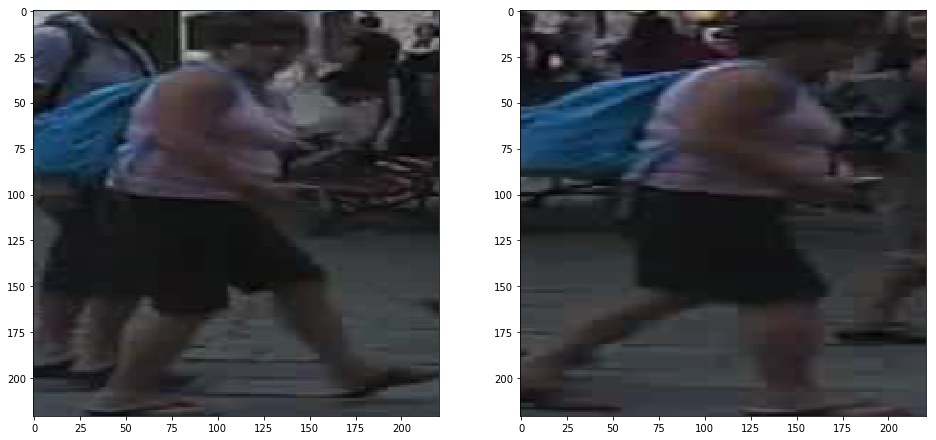

In [3]:
from reid.data import MOT16Sampler

mot_sampler = MOT16Sampler(root, 221, 221)


_start = time()
x, y = mot_sampler.sample()
_end = time()
print('elapsed', _end - _start)

print('same', y[0])

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax.imshow(x[0,:,:,0:3].astype('uint8'))
ax = fig.add_subplot(122)
ax.imshow(x[0,:,:,3:6].astype('uint8'))
plt.show()

## Training

In [4]:
from keras.callbacks import ModelCheckpoint, TerminateOnNaN
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input

filepath = join('data_storage', 'model.h5')

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, TerminateOnNaN()]

if isfile(filepath):
    model = load_model(filepath)
else:
    model = get_model()

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        3520      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)       295168    
__________

In [5]:
from keras.applications.densenet import DenseNet121
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda
from keras.optimizers import RMSprop
from keras import backend as K


dn = DenseNet121(weights='imagenet', input_shape=(221, 221, 3),
    include_top=False, pooling='max')


# input_a = Input(shape=(64, 64, 3))
# input_b = Input(shape=(64, 64, 3))

# processed_a = dn(input_a)
# processed_b = dn(input_b)

In [6]:
# def generate_training_data():
#     global sampler
#     while True:
#         X, Y = sampler.get_train_batch(16, 16)
#         X = preprocess_input(X.astype('float64'))
#         yield X, Y

# def generate_validation_data():
#     global sampler
#     while True:
#         X, Y = sampler.get_test_batch(16, 16)
#         X = preprocess_input(X.astype('float64'))
#         yield X, Y

# history = model.fit_generator(generate_training_data(),
#                     validation_data=generate_validation_data(),
#                     validation_steps=5,
#                     steps_per_epoch=100,
#                     epochs=1000,
#                     callbacks=callbacks_list)